# Imports

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2

# Helper functions

In [2]:
def project(data,comp):
  mean = np.mean(data, axis=0)
  Z = data - mean
  
  return np.dot(comp.T,Z.T).T

def knn(n_neighbors,train,train_y,test,test_y,con=False):
  knn =  KNeighborsClassifier(n_neighbors)
  knn.fit(train,train_y)
  y_pred = knn.predict(test)
  acc = accuracy_score(test_y,y_pred) 
  if con:
    print('\nAccuracy:',acc,'\n')
    confusion_matrix = metrics.confusion_matrix(test_y, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Non-face', 'Face'])
    cm_display.plot()
    plt.show()

  return acc

def display_data(data,y,title):
  print(f'\n{title}:')
  print(f'Data shape: {data.shape}')
  df = pd.DataFrame(data)
  df['Id'] = y

  print('\nValue counts:')
  plt.figure(figsize=(12,8))

  sns.countplot(x=df['Id'])
  plt.show()


  sample = data[np.random.choice(data.shape[0], 
                                  size=6, 
                                  replace=False),:]

  print('\nSample from data:')
  plt.figure(figsize=(12,8))
  i=1
  for s in sample:
    plt.subplot(2,3,i)
    plt.imshow(s.reshape(112,92),cmap='gray')
    i+=1
  plt.show()


def show_dimensions(comp,train,test,alpha=False):
  if alpha:
    print(f'\n@ ɑlpha = {alpha}')
  print("\nReduction dimensions:",comp.shape[1])
  print("Train reduced dimensions:",train.T.shape)
  print("Test reduced dimensions:",test.T.shape)


def plot(x,y,xl,yl):
  plt.plot(x,y,linestyle='--', marker='o', color='r', label='line with marker')
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.legend()
  plt.show()

def show_faces(imgs):
  plt.figure(figsize=(16,8))
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[:,i].reshape(112,92),cmap='gray')
  plt.show()

# Data Matrix and Label Vector


Dataset:
Data shape: (400, 10304)

Value counts:


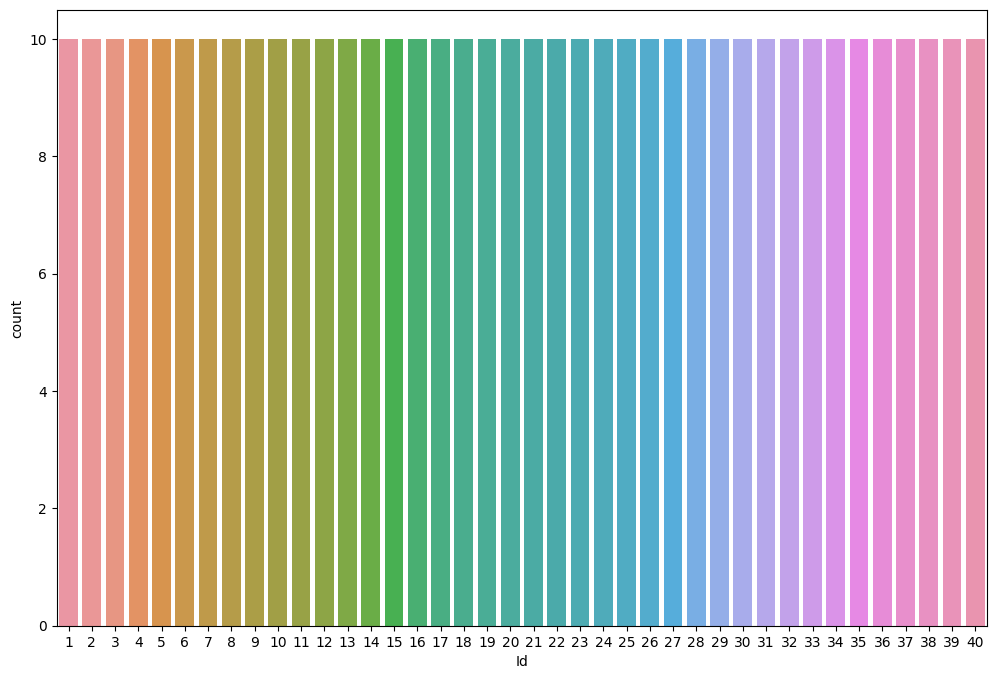


Sample from data:


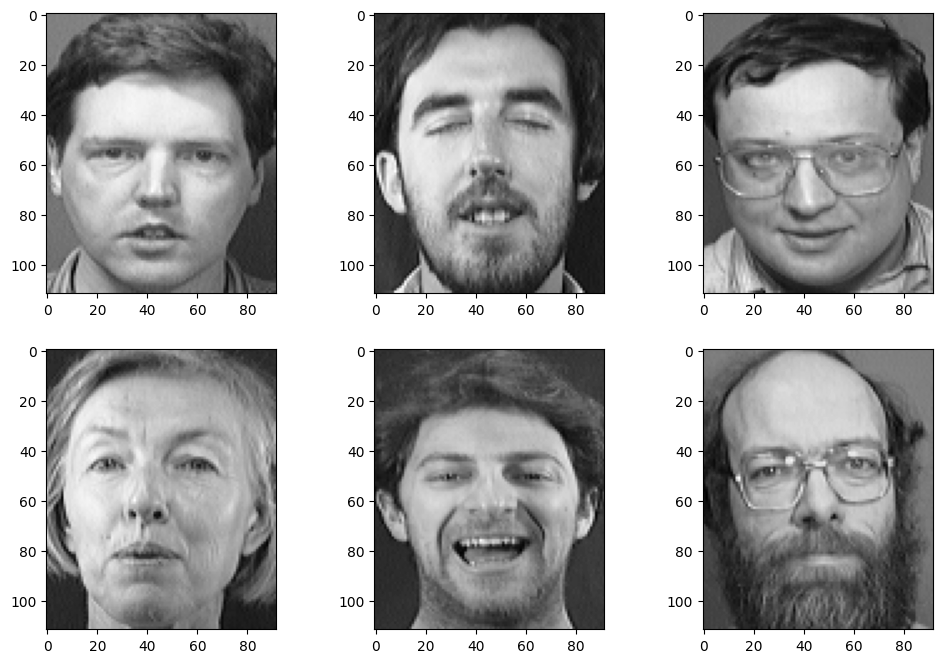

In [3]:
data = np.zeros(shape=(10304, ), dtype= np.int8)
y = np.array([])

for i in range(1,41):
  for j in range(1,11):
    img = Image.open(f'data/att/s{i}/{j}.pgm')
    imgData = np.asarray(img).reshape(-1)
    data = np.vstack((data,imgData))
    y = np.append(y,i)

y = y.astype('int8')
data = data[1:]

display_data(data,y,'Dataset')

# Data Split


Train data:
Data shape: (200, 10304)

Value counts:


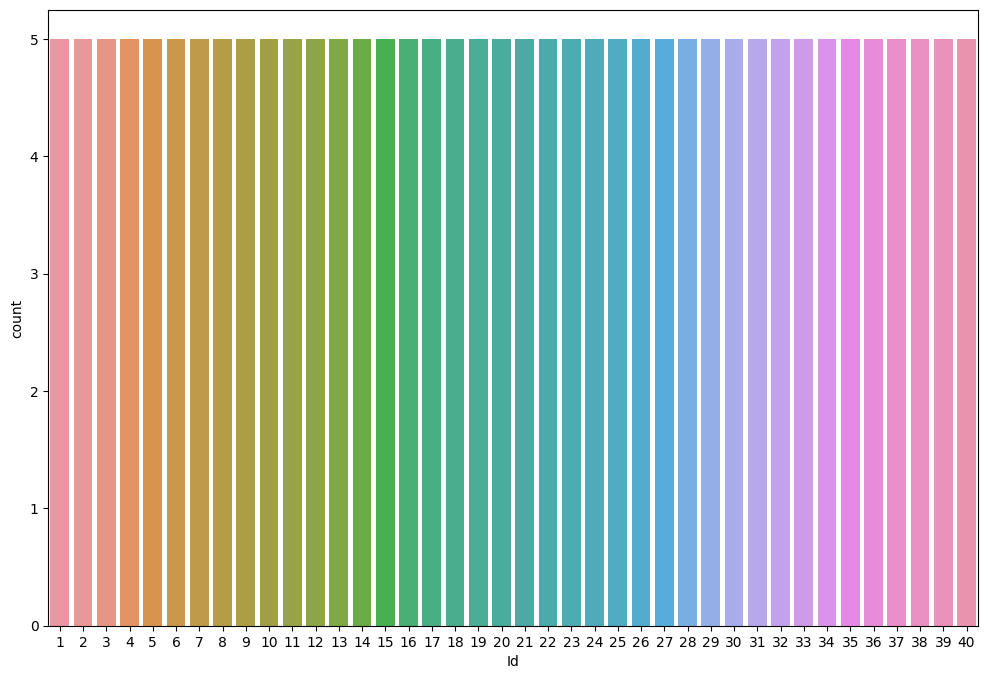


Sample from data:


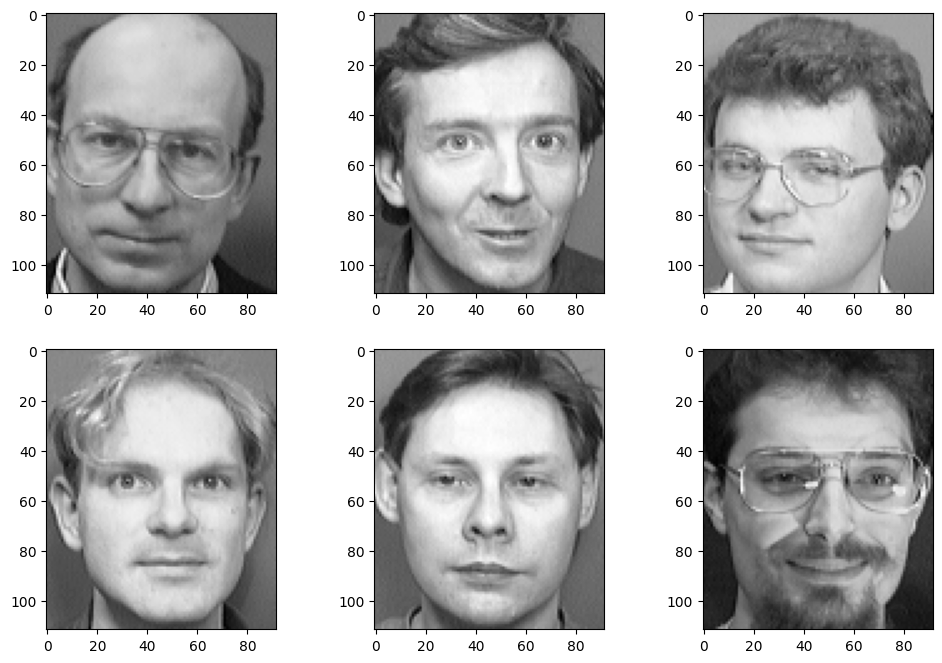


Test data:
Data shape: (200, 10304)

Value counts:


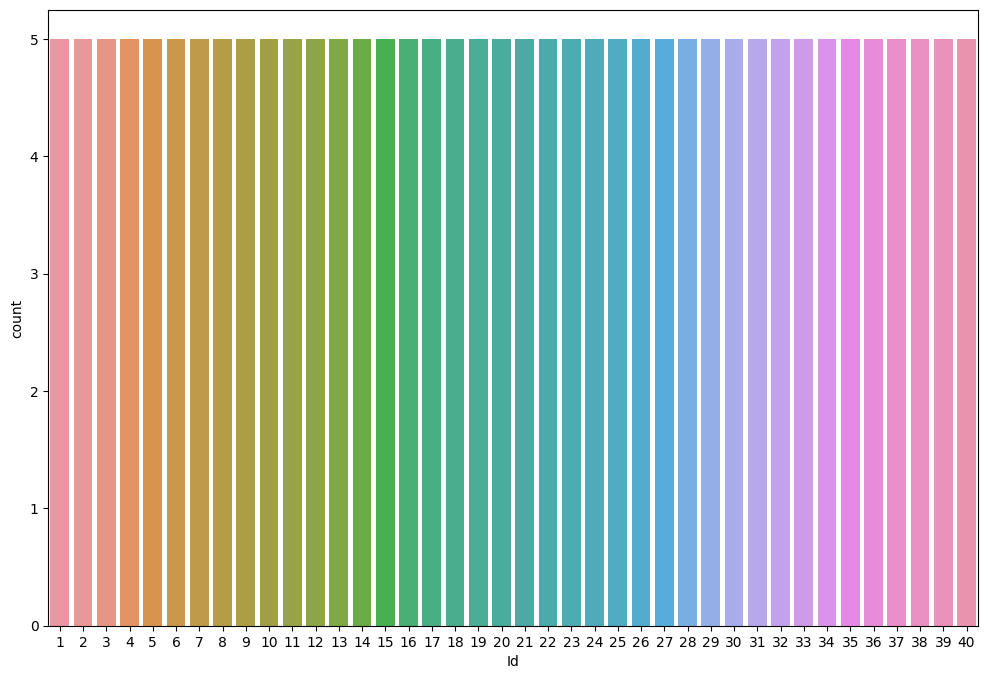


Sample from data:


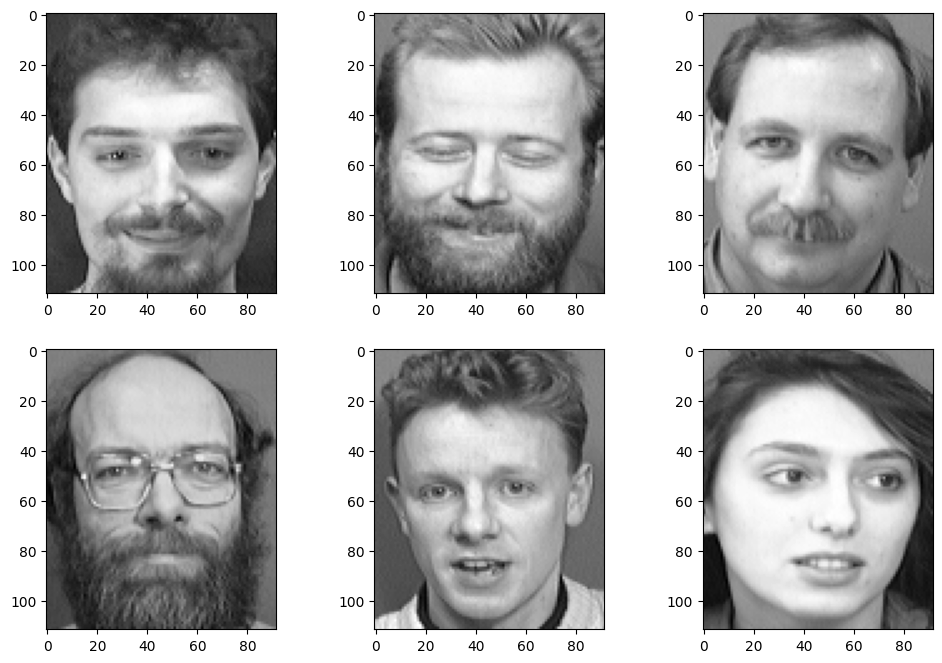

In [4]:
train, test, train_y, test_y = train_test_split(data, y, test_size=0.5, random_state=42,stratify = y)

display_data(train,train_y,'Train data')
display_data(test,test_y,'Test data')

# Classification using PCA

In [5]:
def PCA(data):
  # Step 1: Compute the mean of the data matrix X
  mean = np.mean(data, axis=0)

  # Step 2: Compute the centered data matrix Z
  Z = data - mean

  # Step 3: Compute the covariance matrix C
  C = np.cov(Z.T,bias=True)

  # Step 4: Compute the eigenvalues and eigenvectors of C
  eigenvalues, eigenvectors = np.linalg.eigh(C)

  # Step 5: Sort the eigenvalues and eigenvectors in decreasing order of eigenvalues
  indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[indices]
  eigenvectors = eigenvectors[:, indices]

  return eigenvectors,eigenvalues

In [6]:
def find_R(eigenvectors,eigenvalues,alpha):
  # Step 6: Compute dimensions of reduction corresponding to given alpha value
  fr = 0
  sumEigens = sum(eigenvalues)
  r = 0

  while fr < alpha:
    r+=1
    fr = sum(eigenvalues[:r]) / sumEigens

  # Step 7: Choose the reduced basis
  return eigenvectors[:,:r]

In [7]:
# get the eigen faces
eigenvectors,eigenvalues = PCA(train)

Top 5 eigenfaces:



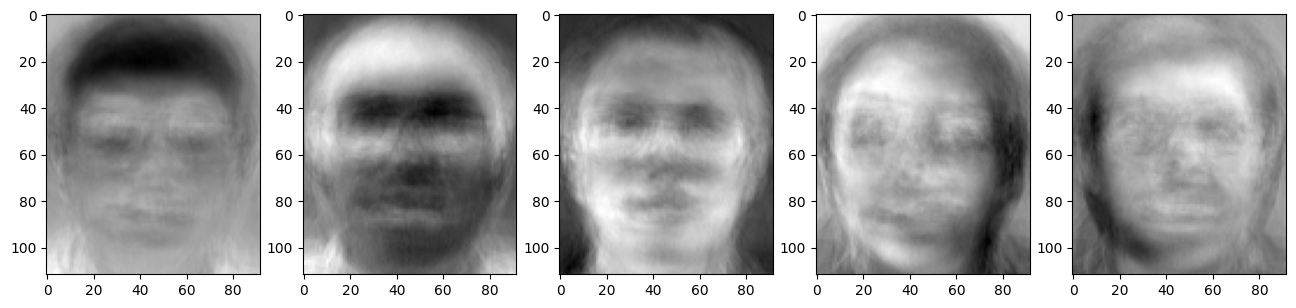

In [8]:
# a.Use the pseudo code below for computing the projection matrix U.
# Define the alpha = {0.8,0.85,0.9,0.95}

print('Top 5 eigenfaces:\n')
show_faces(eigenvectors[:,:5])

# compute reduction dimensions per alpha
U1 = find_R(eigenvectors,eigenvalues,0.8)

U2 = find_R(eigenvectors,eigenvalues,0.85)

U3 = find_R(eigenvectors,eigenvalues,0.9)

U4 = find_R(eigenvectors,eigenvalues,0.95)



In [9]:
# b. Project the training set, and test sets separately using the same
# projection matrix
train1 = project(train,U1)
test1 = project(test,U1)
show_dimensions(U1,train1,test1,0.8)


train2 = project(train,U2)
test2 = project(test,U2)
show_dimensions(U2,train2,test2,0.85)


train3 = project(train,U3)
test3 = project(test,U3)
show_dimensions(U3,train3,test3,0.9)


train4 = project(train,U4)
test4 = project(test,U4)
show_dimensions(U4,train4,test4,0.95)



@ ɑlpha = 0.8

Reduction dimensions: 35
Train reduced dimensions: (35, 200)
Test reduced dimensions: (35, 200)

@ ɑlpha = 0.85

Reduction dimensions: 51
Train reduced dimensions: (51, 200)
Test reduced dimensions: (51, 200)

@ ɑlpha = 0.9

Reduction dimensions: 75
Train reduced dimensions: (75, 200)
Test reduced dimensions: (75, 200)

@ ɑlpha = 0.95

Reduction dimensions: 114
Train reduced dimensions: (114, 200)
Test reduced dimensions: (114, 200)


Accuracy vector:  [0.935, 0.94, 0.945, 0.945] 




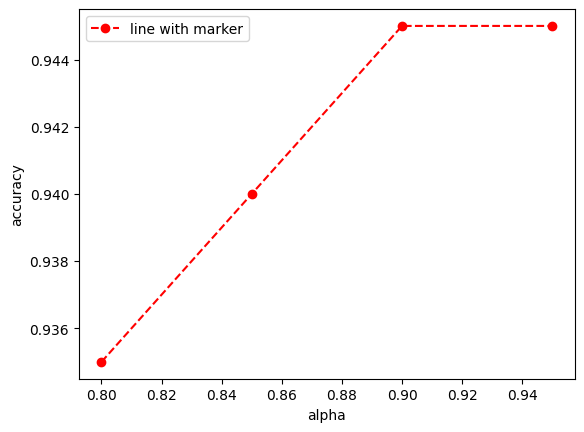

In [10]:
# c. Use a simple classifier (first Nearest Neighbor to determine the class
# labels)
acc1 = knn(1,train1,train_y,test1,test_y)
acc2 = knn(1,train2,train_y,test2,test_y)
acc3 = knn(1,train3,train_y,test3,test_y)
acc4 = knn(1,train4,train_y,test4,test_y)

# d. Report Accuracy for every value of alpha separately
accs = [acc1,acc2,acc3,acc4]
print('Accuracy vector: ',accs,'\n\n')

plot([0.8,0.85,0.9,0.95],accs,'alpha','accuracy')

# Classifier Tuning using K-NN =[1,3,5,7]

## PCA accuracy measure against number of neighbors

In [11]:
for neighbors in range(1,9,2):
  print("At k=",neighbors,"\n")
  acc1 = knn(neighbors,train1,train_y,test1,test_y)
  acc2 = knn(neighbors,train2,train_y,test2,test_y)
  acc3 = knn(neighbors,train3,train_y,test3,test_y)
  acc4 = knn(neighbors,train4,train_y,test4,test_y)
  accs = [acc1,acc2,acc3,acc4]
  print('Accuracy vector: ',accs,'\n\n')



At k= 1 

Accuracy vector:  [0.935, 0.94, 0.945, 0.945] 


At k= 3 

Accuracy vector:  [0.89, 0.87, 0.85, 0.855] 


At k= 5 

Accuracy vector:  [0.795, 0.795, 0.785, 0.785] 


At k= 7 

Accuracy vector:  [0.76, 0.77, 0.755, 0.725] 




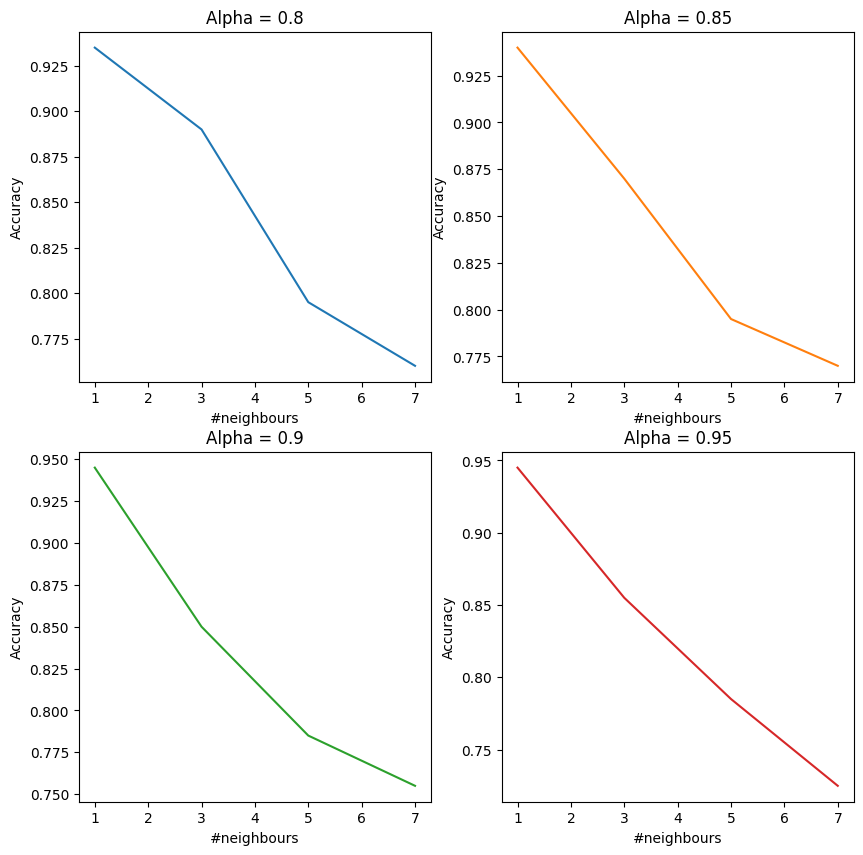

In [12]:
#for alpha=0.8
fig,axs=plt.subplots(2,2,figsize=(10,10))
PCA_y8=np.array([0.935,0.89,0.795,0.76])
PCA_x8=np.array([1,3,5,7])
axs[0,0].set_title("Alpha = 0.8")
axs[0,0].plot(PCA_x8,PCA_y8,'tab:blue')
axs[0,0].set_xlabel('#neighbours')
axs[0,0].set_ylabel('Accuracy')

#for alpha=0.85

PCA_y85=np.array([0.94,0.87,0.795,0.77])
PCA_x85=np.array([1,3,5,7])
axs[0,1].set_title("Alpha = 0.85")
axs[0,1].plot(PCA_x85,PCA_y85,'tab:orange')
axs[0,1].set_xlabel('#neighbours')
axs[0,1].set_ylabel('Accuracy')

#for alpha=0.9

PCA_y9=np.array([0.945,0.85,0.785,0.755])
PCA_x9=np.array([1,3,5,7])
axs[1,0].set_title("Alpha = 0.9")
axs[1,0].plot(PCA_x9,PCA_y9,'tab:green')
axs[1,0].set_xlabel('#neighbours')
axs[1,0].set_ylabel('Accuracy')

#for alpha=0.95

PCA_y95=np.array([0.945,0.855,0.785,0.725])
PCA_x95=np.array([1,3,5,7])
axs[1,1].set_title("Alpha = 0.95")
axs[1,1].plot(PCA_x95,PCA_y95,'tab:red')
axs[1,1].set_xlabel('#neighbours')
axs[1,1].set_ylabel('Accuracy')

plt.show()

# Compare vs Non faces

In [13]:
faces2=[]
target2=[]
for i in range(1, 41):
  for j in range (1,11):
    with open('data/att/s'+str(i)+'/'+str(j)+'.pgm','rb') as imgf:
      image = plt.imread(imgf)
      image=image.transpose()
      im=image.flatten()
      faces2.append(im)
      target2.append(1)
for i in range (1,401):
    with open('data/turtles/Turtle_Tortoise ('+str(i)+').jpg','rb') as imgn:
      image2=plt.imread(imgn)
      image_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
      resized_image = cv2.resize(image_rgb, (92, 112))
      image2=resized_image.transpose()
      im2=image2.flatten()
      faces2.append(im2)
      target2.append(0)
faces=np.array(faces2)
target=np.array(target2)
target=np.reshape(target,(800,1))


In [14]:
def readd(R):
  faces2=[]
  target2=[]
  for i in range(1, 41):
    for j in range (1,11):
      with open('data/att/s'+str(i)+'/'+str(j)+'.pgm','rb') as imgf:
       image = plt.imread(imgf)
       image=image.transpose()
       im=image.flatten()
       faces2.append(im)
       target2.append(1)
  for i in range (1,R+1):
    with open('data/turtles/Turtle_Tortoise ('+str(i)+').jpg','rb') as imgn:
      image2=plt.imread(imgn)
      image_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
      resized_image = cv2.resize(image_rgb, (92, 112))
      image2=resized_image.transpose()
      im2=image2.flatten()
      faces2.append(im2)
      target2.append(0)
  faces=np.array(faces2)
  target=np.array(target2)
  target=np.reshape(target,(R+400,1))
  return(faces,target) 


## 200 non-face images vs 400 face images (unbalanced)

In [15]:
fn2,tn2=readd(200)
display(tn2.shape)

train_n2, test_n2, train_yn2, test_yn2 = train_test_split(fn2, tn2, test_size=0.5, random_state=42,stratify = tn2)

(600, 1)

##### PCA

In [16]:
# get the eigen faces
eigenvectors,eigenvalues = PCA(train_n2)

In [17]:
U1n2 = find_R(eigenvectors,eigenvalues,0.8)

U2n2 = find_R(eigenvectors,eigenvalues,0.85)

U3n2 = find_R(eigenvectors,eigenvalues,0.9)

U4n2 = find_R(eigenvectors,eigenvalues,0.95)

In [18]:
train1n2 = project(train_n2,U1n2)
test1n2 = project(test_n2,U1n2)
show_dimensions(U1n2,train1n2,test1n2,0.8)


train2n2 = project(train_n2,U2n2)
test2n2 = project(test_n2,U2n2)
show_dimensions(U2n2,train2n2,test2n2,0.85)


train3n2 = project(train_n2,U3n2)
test3n2 = project(test_n2,U3n2)
show_dimensions(U3n2,train3n2,test3n2,0.9)


train4n2 = project(train_n2,U2n2)
test4n2 = project(test_n2,U2n2)
show_dimensions(U4n2,train4n2,test4n2,0.95)


@ ɑlpha = 0.8

Reduction dimensions: 40
Train reduced dimensions: (40, 300)
Test reduced dimensions: (40, 300)

@ ɑlpha = 0.85

Reduction dimensions: 60
Train reduced dimensions: (60, 300)
Test reduced dimensions: (60, 300)

@ ɑlpha = 0.9

Reduction dimensions: 90
Train reduced dimensions: (90, 300)
Test reduced dimensions: (90, 300)

@ ɑlpha = 0.95

Reduction dimensions: 143
Train reduced dimensions: (60, 300)
Test reduced dimensions: (60, 300)



Accuracy: 0.9766666666666667 



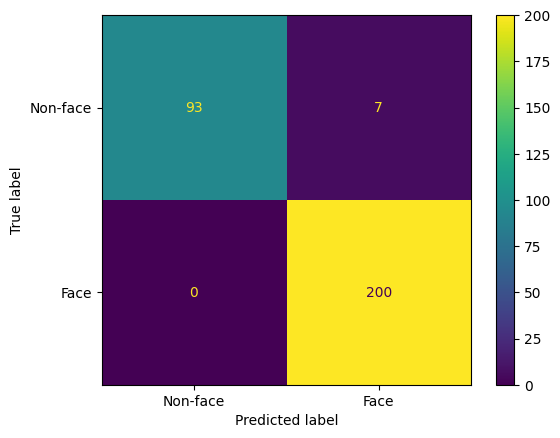


Accuracy: 0.9766666666666667 



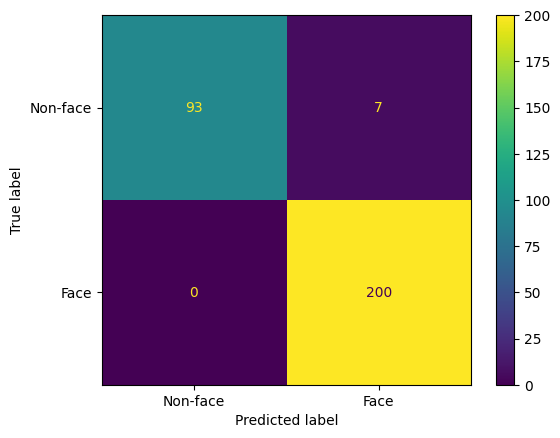


Accuracy: 0.9766666666666667 



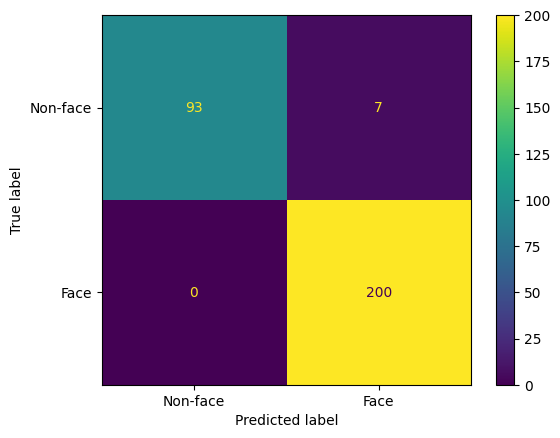


Accuracy: 0.9766666666666667 



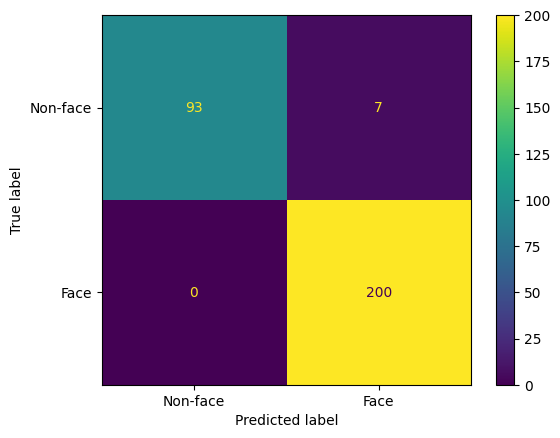


Accuracy vector:  [0.9766666666666667, 0.9766666666666667, 0.9766666666666667, 0.9766666666666667] 



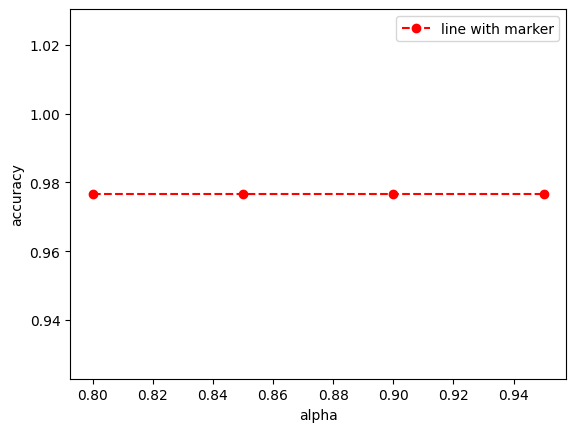

In [19]:
acc1n2 = knn(1,train1n2,train_yn2.reshape(-1),test1n2,test_yn2.reshape(-1),True)
acc2n2 = knn(1,train2n2,train_yn2.reshape(-1),test2n2,test_yn2.reshape(-1),True)
acc3n2 = knn(1,train3n2,train_yn2.reshape(-1),test3n2,test_yn2.reshape(-1),True)
acc4n2 = knn(1,train4n2,train_yn2.reshape(-1),test4n2,test_yn2.reshape(-1),True)

# d. Report Accuracy for every value of alpha separately
accsn2 = [acc1n2,acc2n2,acc3n2,acc4n2]
print('\nAccuracy vector: ',accsn2,'\n')

plot([0.8,0.85,0.9,0.95],accsn2,'alpha','accuracy')

## 400 non face images vs 400 face images(balanced)

In [20]:
fn4,tn4=readd(400)
display(tn4.shape)

train_n4, test_n4, train_yn4, test_yn4 = train_test_split(fn4, tn4, test_size=0.5, random_state=42,stratify = tn4)

(800, 1)

##### PCA

In [21]:
# get the eigen faces
eigenvectors,eigenvalues = PCA(train_n4)

In [22]:
U1n4 = find_R(eigenvectors,eigenvalues,0.8)

U2n4 = find_R(eigenvectors,eigenvalues,0.85)

U3n4 = find_R(eigenvectors,eigenvalues,0.9)

U4n4 = find_R(eigenvectors,eigenvalues,0.95)

In [23]:
train1n4 = project(train_n4,U1n4)
test1n4 = project(test_n4,U1n4)
show_dimensions(U1n4,train1n4,test1n4,0.8)


train2n4 = project(train_n4,U2n4)
test2n4 = project(test_n4,U2n4)
show_dimensions(U2n4,train2n4,test2n4,0.85)


train3n4 = project(train_n4,U3n4)
test3n4 = project(test_n4,U3n4)
show_dimensions(U3n4,train3n4,test3n4,0.9)


train4n4 = project(train_n4,U4n4)
test4n4 = project(test_n4,U4n4)
show_dimensions(U4n4,train4n4,test4n4,0.95)


@ ɑlpha = 0.8

Reduction dimensions: 47
Train reduced dimensions: (47, 400)
Test reduced dimensions: (47, 400)

@ ɑlpha = 0.85

Reduction dimensions: 74
Train reduced dimensions: (74, 400)
Test reduced dimensions: (74, 400)

@ ɑlpha = 0.9

Reduction dimensions: 116
Train reduced dimensions: (116, 400)
Test reduced dimensions: (116, 400)

@ ɑlpha = 0.95

Reduction dimensions: 189
Train reduced dimensions: (189, 400)
Test reduced dimensions: (189, 400)



Accuracy: 0.9825 



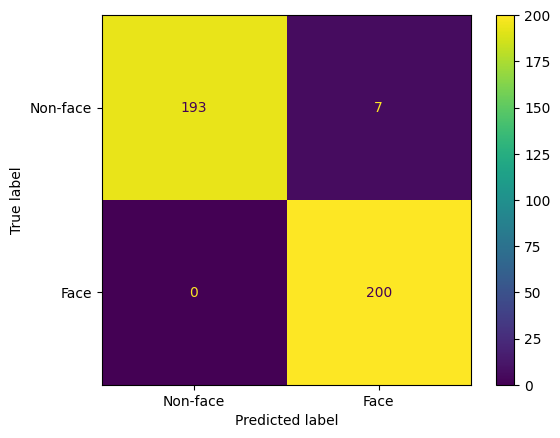


Accuracy: 0.9825 



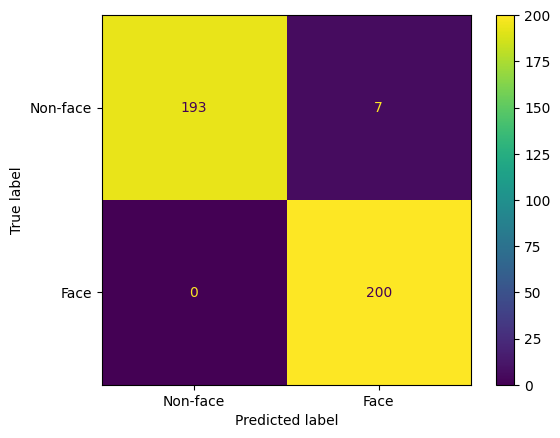


Accuracy: 0.985 



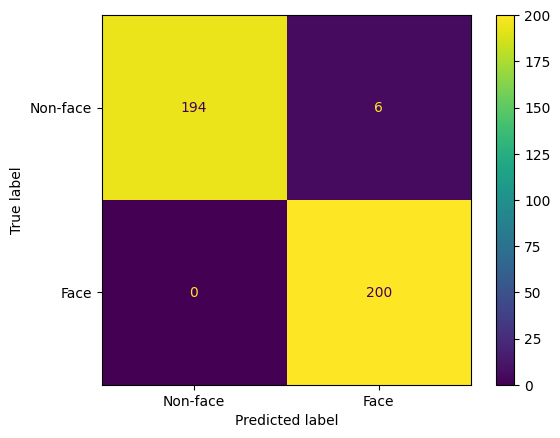


Accuracy: 0.985 



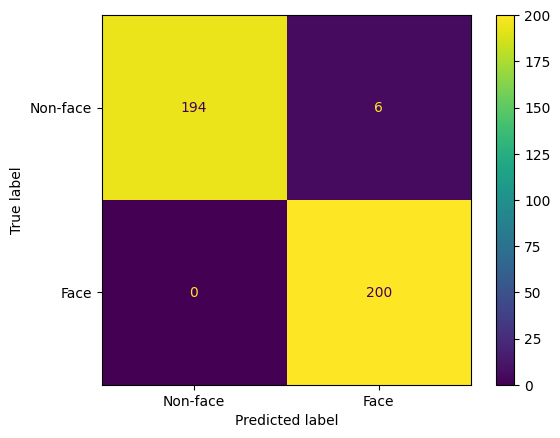


Accuracy vector:  [0.9825, 0.9825, 0.985, 0.985] 



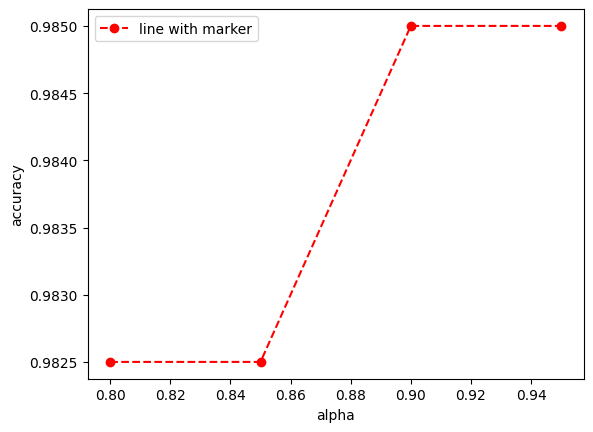

In [24]:
acc1n4 = knn(1,train1n4,train_yn4.reshape(-1),test1n4,test_yn4.reshape(-1),True)
acc2n4 = knn(1,train2n4,train_yn4.reshape(-1),test2n4,test_yn4.reshape(-1),True)
acc3n4 = knn(1,train3n4,train_yn4.reshape(-1),test3n4,test_yn4.reshape(-1),True)
acc4n4 = knn(1,train4n4,train_yn4.reshape(-1),test4n4,test_yn4.reshape(-1),True)

# d. Report Accuracy for every value of alpha separately
accsn4 = [acc1n4,acc2n4,acc3n4,acc4n4]
print('\nAccuracy vector: ',accsn4,'\n')

plot([0.8,0.85,0.9,0.95],accsn4,'alpha','accuracy')

## 600 non face images vs 400 face images(unbalanced)

In [25]:
fn6,tn6=readd(600)
display(tn6.shape)

train_n6, test_n6, train_yn6, test_yn6 = train_test_split(fn6, tn6, test_size=0.5, random_state=42,stratify = tn6)

(1000, 1)

##### PCA

In [26]:
# get the eigen faces
eigenvectors,eigenvalues = PCA(train_n6)

In [27]:
U1n6 = find_R(eigenvectors,eigenvalues,0.8)

U2n6 = find_R(eigenvectors,eigenvalues,0.85)

U3n6 = find_R(eigenvectors,eigenvalues,0.9)

U4n6 = find_R(eigenvectors,eigenvalues,0.95)

In [28]:
train1n6 = project(train_n6,U1n6)
test1n6 = project(test_n6,U1n6)
show_dimensions(U1n6,train1n6,test1n6,0.8)


train2n6 = project(train_n6,U2n6)
test2n6 = project(test_n6,U2n6)
show_dimensions(U2n6,train2n6,test2n6,0.85)


train3n6 = project(train_n6,U3n6)
test3n6 = project(test_n6,U3n6)
show_dimensions(U3n6,train3n6,test3n6,0.9)


train4n6 = project(train_n6,U4n6)
test4n6 = project(test_n6,U4n6)
show_dimensions(U4n6,train4n6,test4n6,0.95)


@ ɑlpha = 0.8

Reduction dimensions: 51
Train reduced dimensions: (51, 500)
Test reduced dimensions: (51, 500)

@ ɑlpha = 0.85

Reduction dimensions: 83
Train reduced dimensions: (83, 500)
Test reduced dimensions: (83, 500)

@ ɑlpha = 0.9

Reduction dimensions: 135
Train reduced dimensions: (135, 500)
Test reduced dimensions: (135, 500)

@ ɑlpha = 0.95

Reduction dimensions: 226
Train reduced dimensions: (226, 500)
Test reduced dimensions: (226, 500)



Accuracy: 0.992 



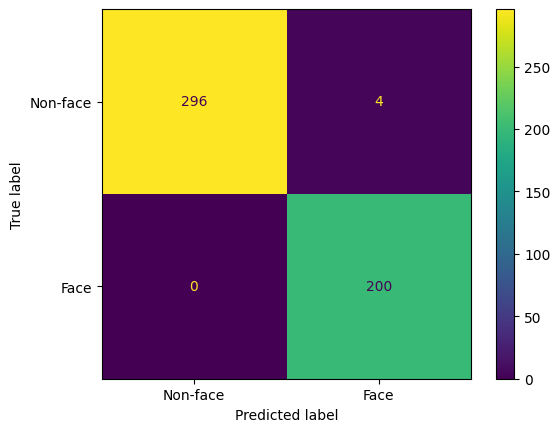


Accuracy: 0.994 



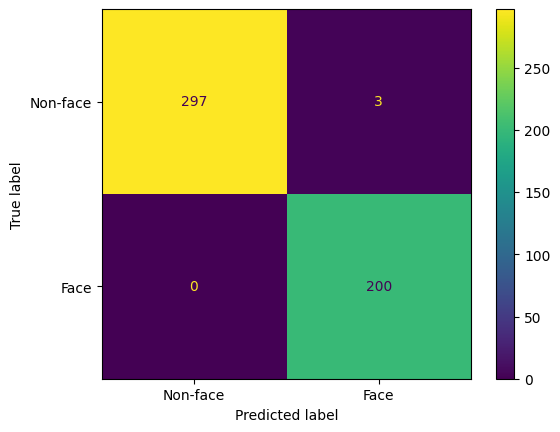


Accuracy: 0.996 



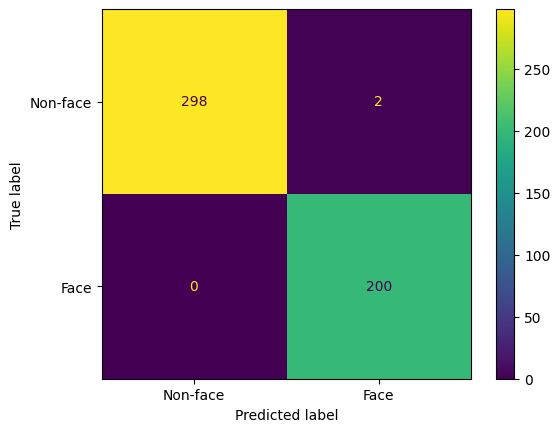


Accuracy: 0.994 



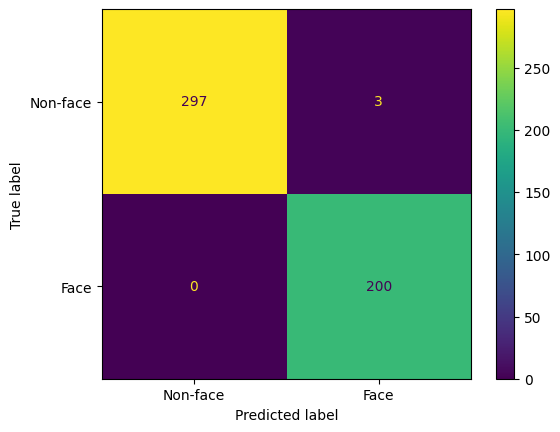

Accuracy vector:  [0.992, 0.994, 0.996, 0.994] 




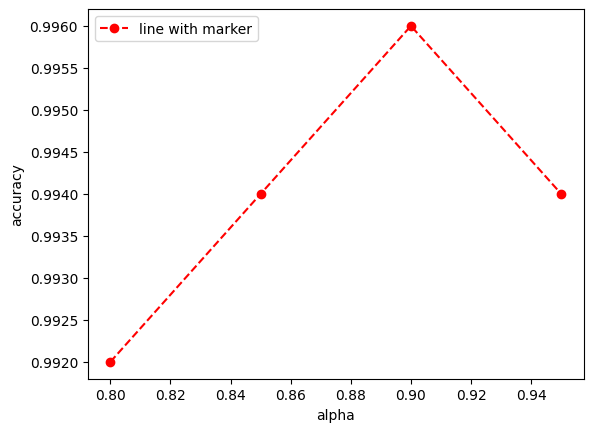

In [29]:
acc1n6 = knn(1,train1n6,train_yn6.reshape(-1),test1n6,test_yn6.reshape(-1),True)
acc2n6 = knn(1,train2n6,train_yn6.reshape(-1),test2n6,test_yn6.reshape(-1),True)
acc3n6 = knn(1,train3n6,train_yn6.reshape(-1),test3n6,test_yn6.reshape(-1),True)
acc4n6 = knn(1,train4n6,train_yn6.reshape(-1),test4n6,test_yn6.reshape(-1),True)

# d. Report Accuracy for every value of alpha separately
accsn6 = [acc1n6,acc2n6,acc3n6,acc4n6]
print('Accuracy vector: ',accsn6,'\n\n')

plot([0.8,0.85,0.9,0.95],accsn6,'alpha','accuracy')

## Accuracy vs the number of non-faces images while fixing the number of face images

### PCA

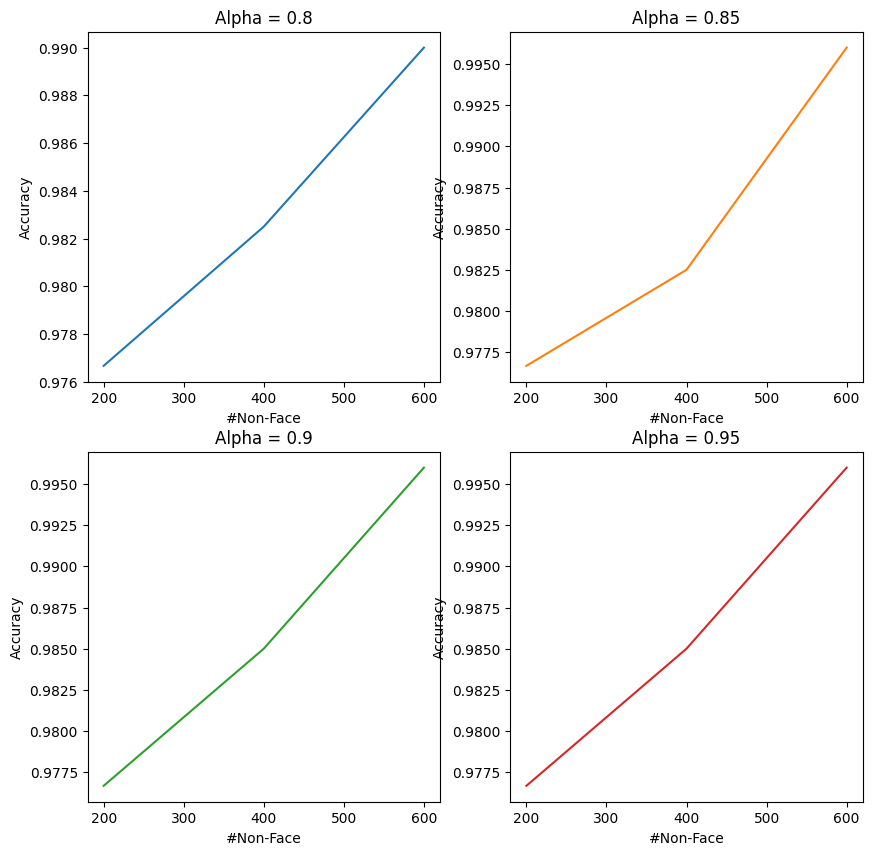

In [30]:
#for alpha=0.8
fig,axs=plt.subplots(2,2,figsize=(10,10))
PCAn_y8=np.array([0.9766666666666667,0.9825,0.99])
PCAn_x8=np.array([200,400,600])
axs[0,0].set_title("Alpha = 0.8")
axs[0,0].plot(PCAn_x8,PCAn_y8,'tab:blue')
axs[0,0].set_xlabel('#Non-Face')
axs[0,0].set_ylabel('Accuracy')

#for alpha=0.85

PCAn_y85=np.array([0.9766666666666667,0.9825,0.996])
PCAn_x85=np.array([200,400,600])
axs[0,1].set_title("Alpha = 0.85")
axs[0,1].plot(PCAn_x85,PCAn_y85,'tab:orange')
axs[0,1].set_xlabel('#Non-Face')
axs[0,1].set_ylabel('Accuracy')

#for alpha=0.9

PCAn_y9=np.array([0.9766666666666667,0.985,0.996])
PCAn_x9=np.array([200,400,600])
axs[1,0].set_title("Alpha = 0.9")
axs[1,0].plot(PCAn_x9,PCAn_y9,'tab:green')
axs[1,0].set_xlabel('#Non-Face')
axs[1,0].set_ylabel('Accuracy')

#for alpha=0.95

PCAn_y95=np.array([0.9766666666666667,0.985,0.996])
PCAn_x95=np.array([200,400,600])
axs[1,1].set_title("Alpha = 0.95")
axs[1,1].plot(PCAn_x95,PCAn_y95,'tab:red')
axs[1,1].set_xlabel('#Non-Face')
axs[1,1].set_ylabel('Accuracy')

plt.show()

# Bonus

## Data split


Train data:
Data shape: (280, 10304)

Value counts:


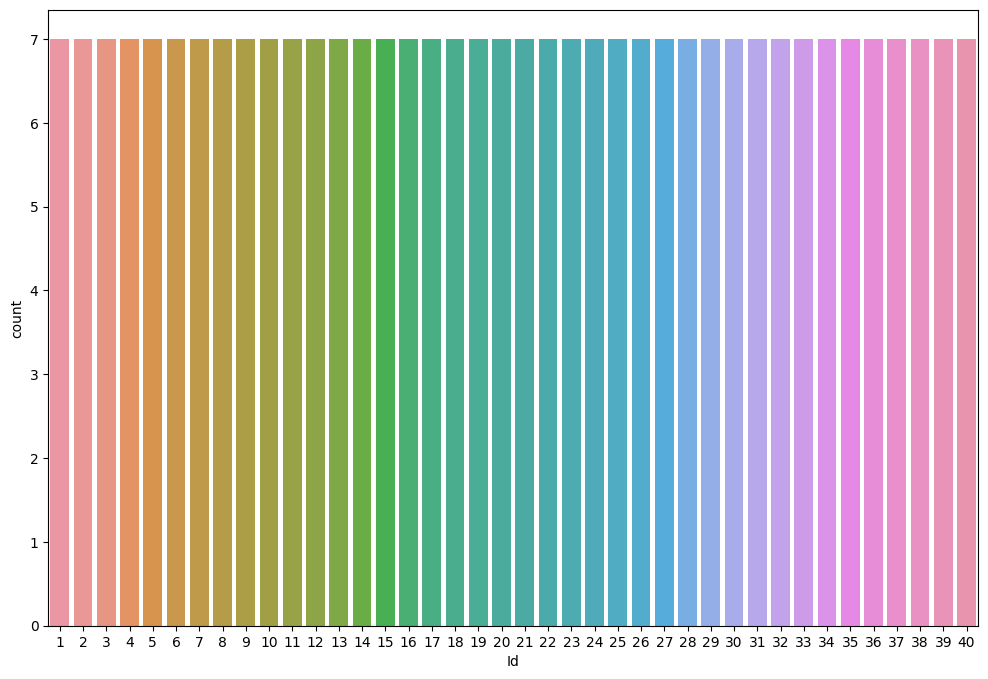


Sample from data:


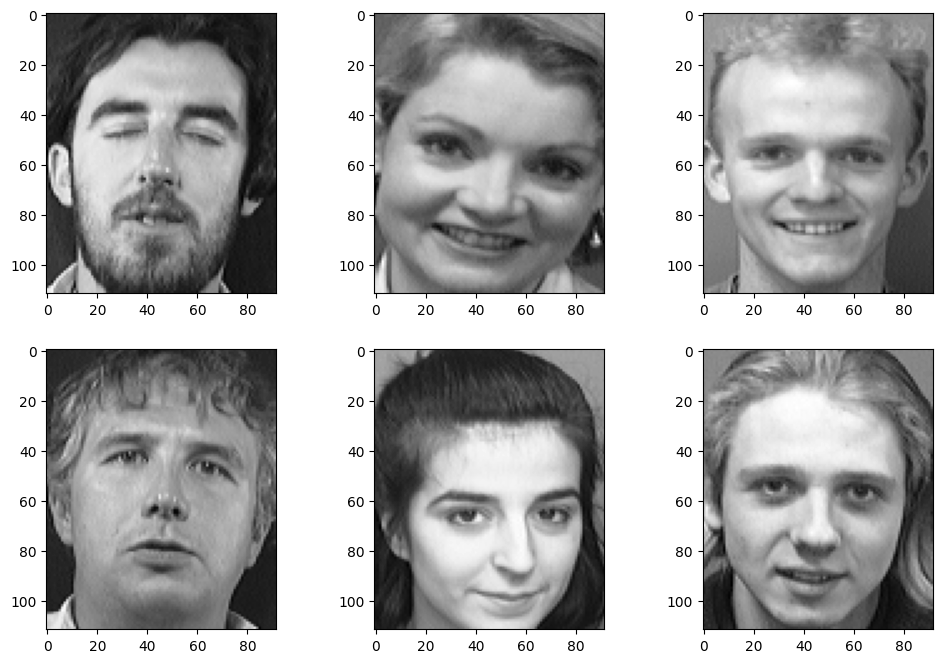


Test data:
Data shape: (120, 10304)

Value counts:


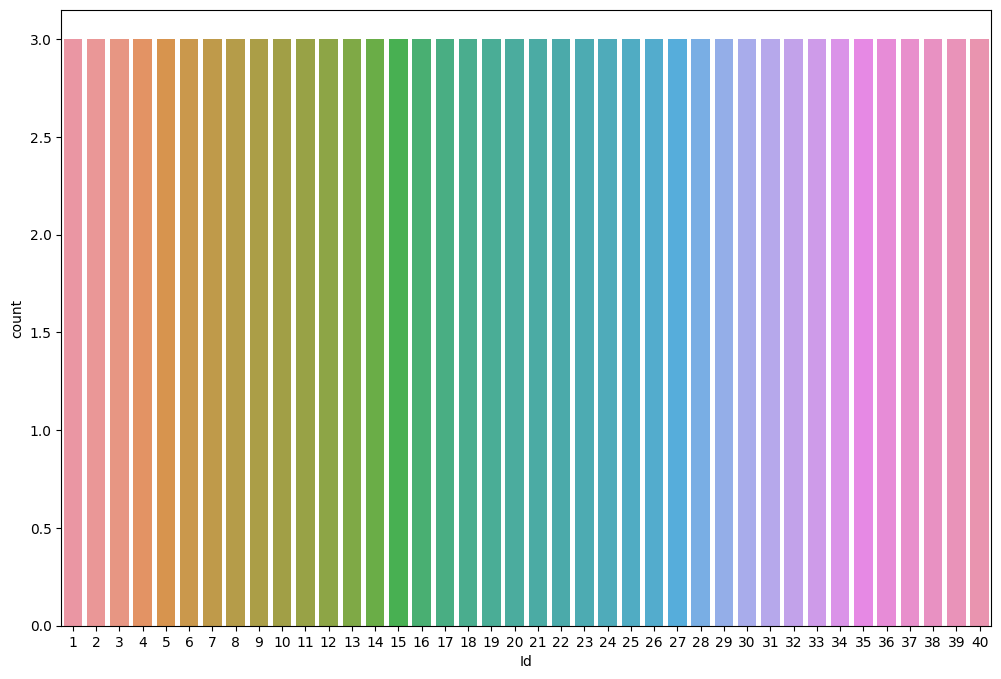


Sample from data:


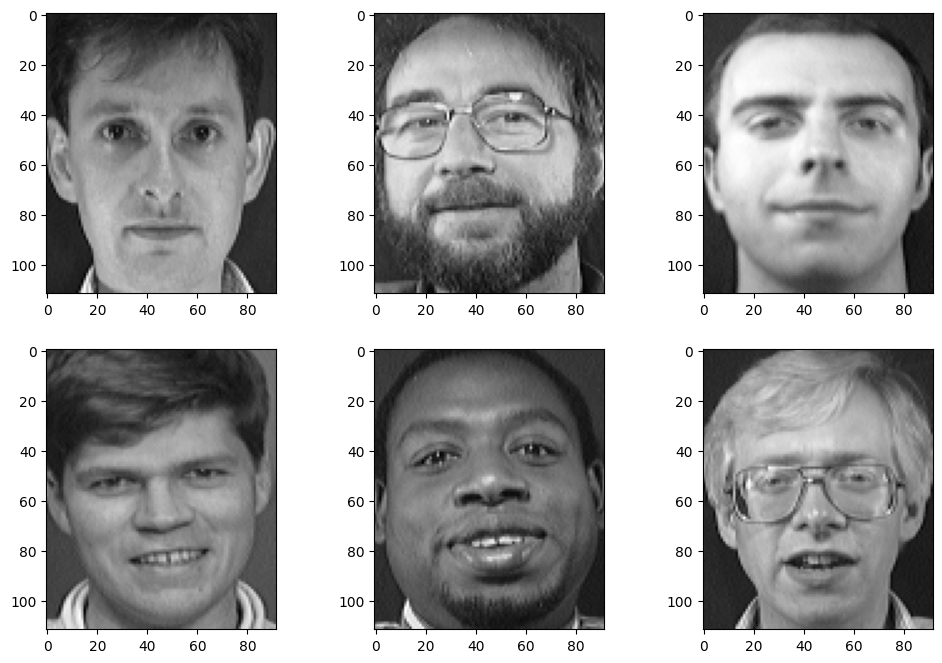

In [31]:
# a. Use different Training and Test splits. Change the number of instances per subject to be 7 and keep 3 instances per subject for testing. compare the results you have with the ones you got earlier with 50% split. 
trainB, testB, trainB_y, testB_y = train_test_split(data, y, test_size=0.3, random_state=42,stratify = y)


display_data(trainB,trainB_y,'Train data')
display_data(testB,testB_y,'Test data')




## PCA

In [32]:
eigenvectors,eigenvalues = PCA(trainB)

Top 5 eigenfaces:



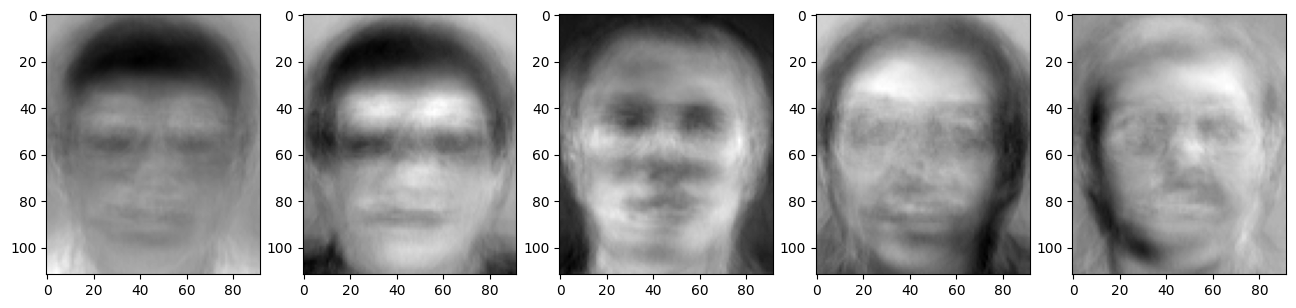

In [33]:
# a.Use the pseudo code below for computing the projection matrix U.
# Define the alpha = {0.8,0.85,0.9,0.95}

print('Top 5 eigenfaces:\n')
show_faces(eigenvectors[:,:5])

# compute reduction dimensions per alpha
U1B = find_R(eigenvectors,eigenvalues,0.8)

U2B = find_R(eigenvectors,eigenvalues,0.85)

U3B = find_R(eigenvectors,eigenvalues,0.9)

U4B = find_R(eigenvectors,eigenvalues,0.95)


In [34]:
# b. Project the training set, and test sets separately using the same
# projection matrix
train1B = project(trainB,U1B)
test1B = project(testB,U1B)
show_dimensions(U1B,train1B,test1B,0.8)

train2B = project(trainB,U2B)
test2B = project(testB,U2B)
show_dimensions(U2B,train2B,test2B,0.85)

train3B = project(trainB,U3B)
test3B = project(testB,U3B)
show_dimensions(U3B,train3B,test3B,0.9)

train4B = project(trainB,U4B)
test4B = project(testB,U4B)
show_dimensions(U4B,train4B,test4B,0.95)



@ ɑlpha = 0.8

Reduction dimensions: 40
Train reduced dimensions: (40, 280)
Test reduced dimensions: (40, 120)

@ ɑlpha = 0.85

Reduction dimensions: 59
Train reduced dimensions: (59, 280)
Test reduced dimensions: (59, 120)

@ ɑlpha = 0.9

Reduction dimensions: 91
Train reduced dimensions: (91, 280)
Test reduced dimensions: (91, 120)

@ ɑlpha = 0.95

Reduction dimensions: 148
Train reduced dimensions: (148, 280)
Test reduced dimensions: (148, 120)


Accuracy vector:  [0.9583333333333334, 0.9416666666666667, 0.9583333333333334, 0.95] 




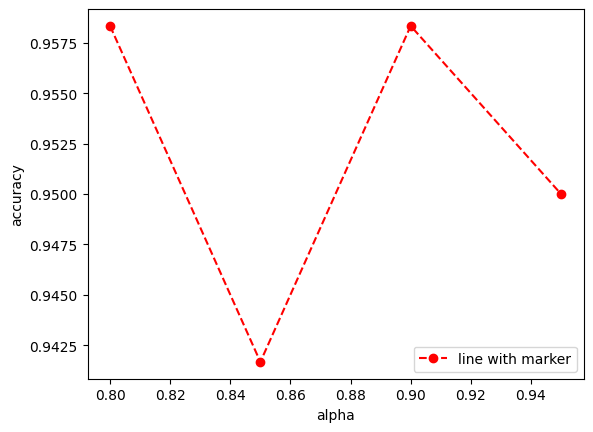

In [35]:
# c. Use a simple classifier (first Nearest Neighbor to determine the class
# labels)
acc1B = knn(1,train1B,trainB_y,test1B,testB_y)
acc2B = knn(1,train2B,trainB_y,test2B,testB_y)
acc3B = knn(1,train3B,trainB_y,test3B,testB_y)
acc4B = knn(1,train4B,trainB_y,test4B,testB_y)

# d. Report Accuracy for every value of alpha separately
accsB = [acc1B,acc2B,acc3B,acc4B]
print('Accuracy vector: ',accsB,'\n\n')

plot([0.8,0.85,0.9,0.95],accsB,'alpha','accuracy')

## sklearn PCA

In [36]:
from sklearn.decomposition import IncrementalPCA as IPCA
pca = IPCA(n_components=91)
 
pca_train = pca.fit_transform(trainB)
pca_test = pca.transform(testB)


In [37]:
knn(1,pca_train,trainB_y,pca_test,testB_y)

0.9583333333333334

# Scaling


Scaled dataset:
Data shape: (400, 10304)

Value counts:


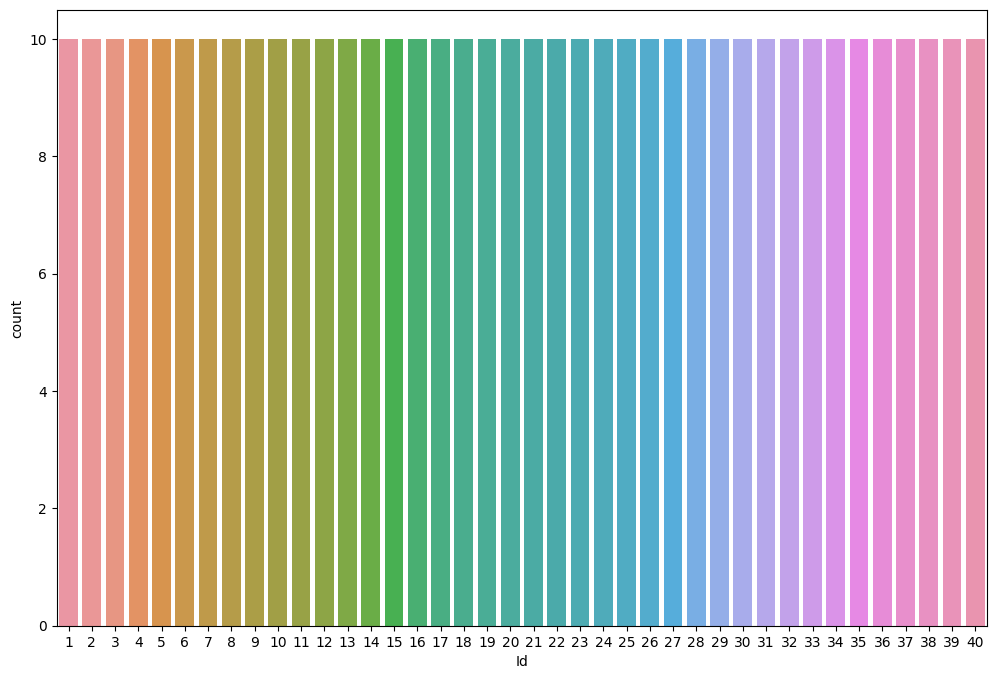


Sample from data:


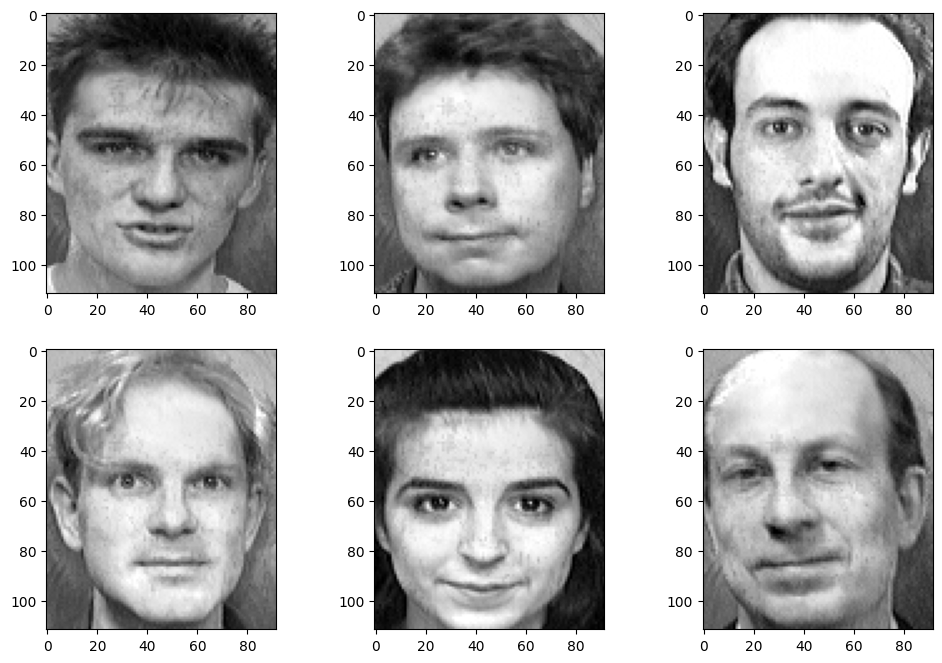

In [38]:
scaler = MinMaxScaler()
dataScaled = scaler.fit_transform(data)

display_data(dataScaled,y,'Scaled dataset')


Train data:
Data shape: (280, 10304)

Value counts:


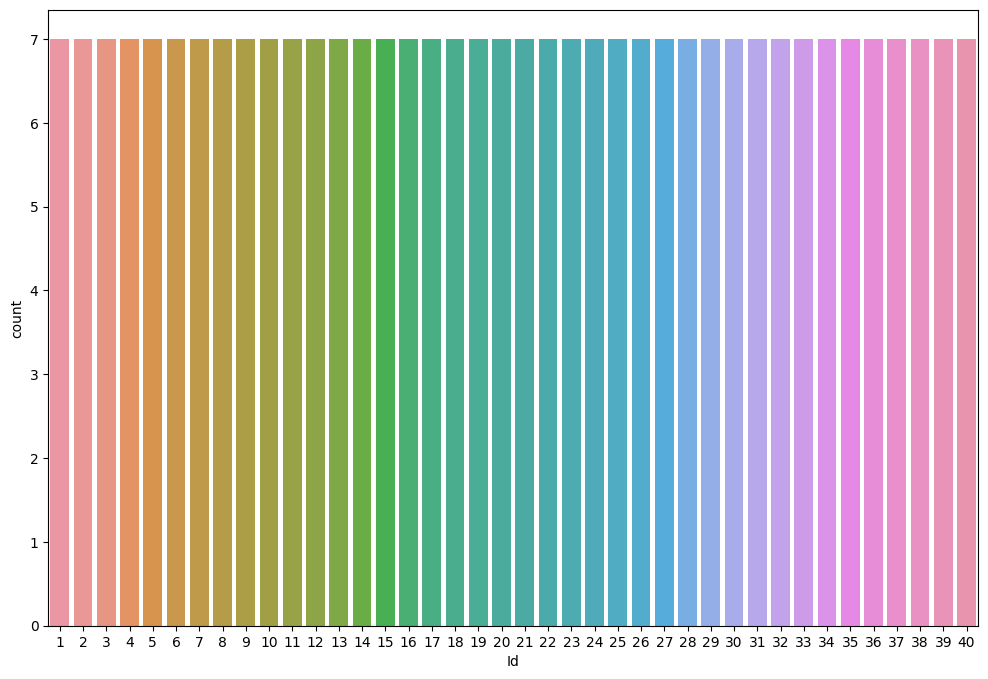


Sample from data:


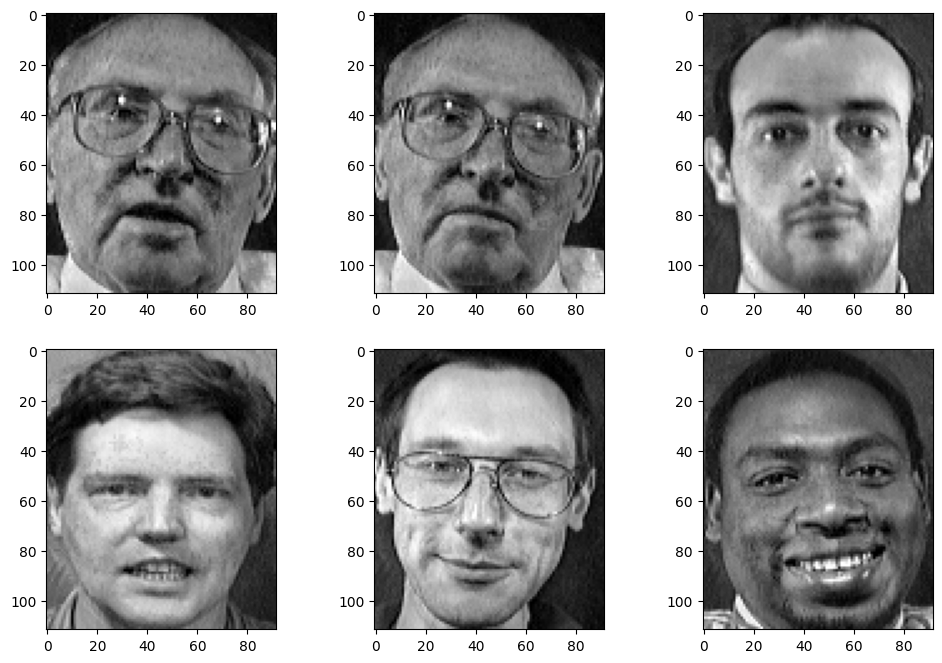


Test data:
Data shape: (120, 10304)

Value counts:


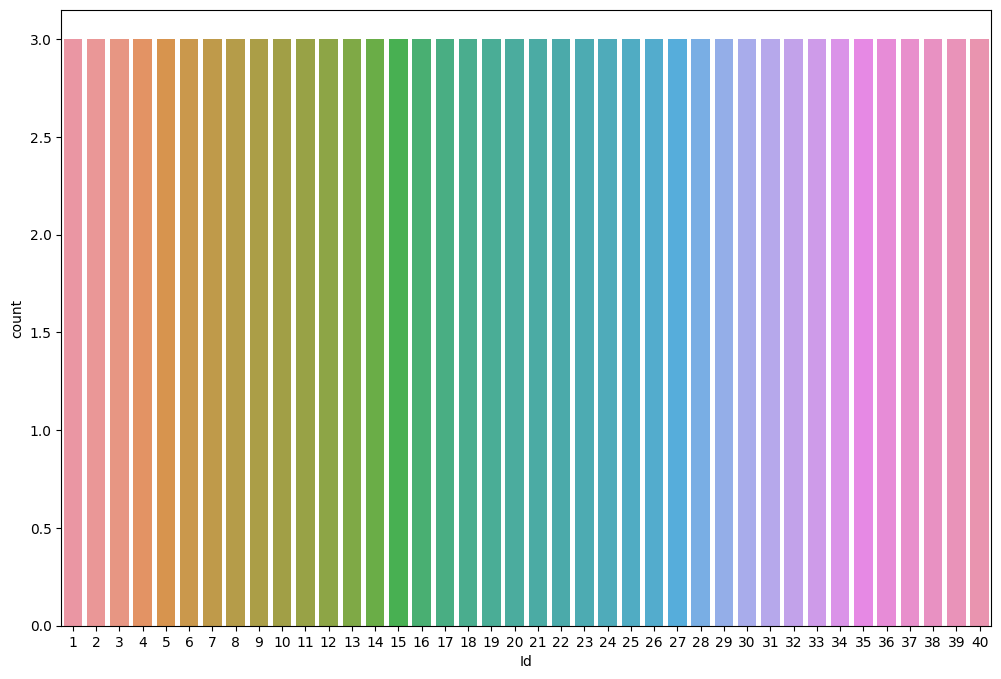


Sample from data:


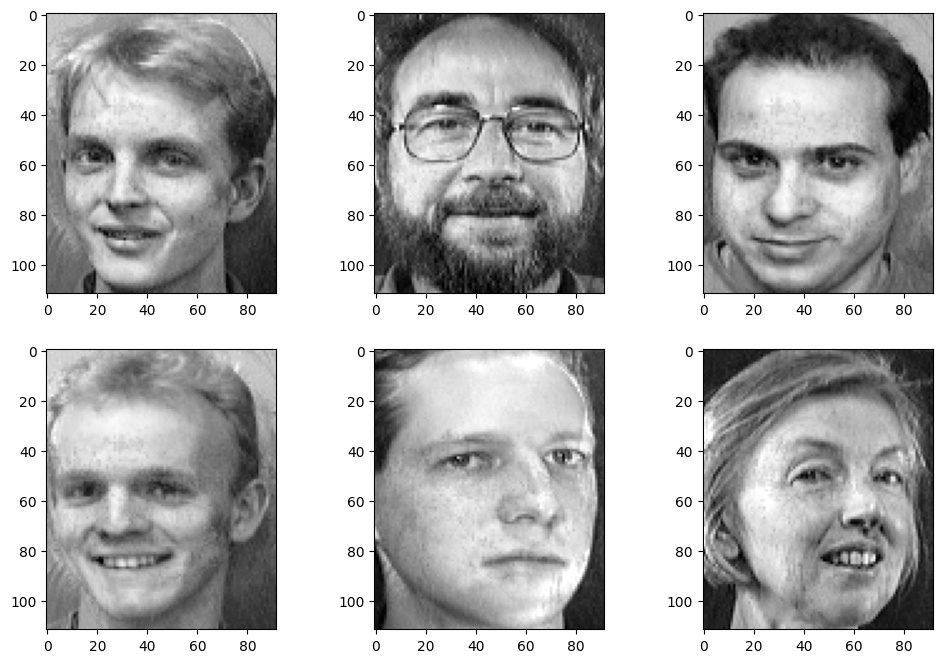

In [39]:
X_train, X_test, y_train, y_test = train_test_split(dataScaled, y, test_size=0.3, random_state=42,stratify = y)

display_data(X_train,y_train,'Train data')
display_data(X_test,y_test,'Test data')

In [40]:
eigenvectors,eigenvalues = PCA(X_train)

In [41]:
Us = find_R(eigenvectors,eigenvalues,0.9)

In [42]:
trainsca = project(X_train,Us)
testsca = project(X_test,Us)
show_dimensions(Us,trainsca,testsca,0.85)


@ ɑlpha = 0.85

Reduction dimensions: 88
Train reduced dimensions: (88, 280)
Test reduced dimensions: (88, 120)


In [43]:
knn(1,trainsca,y_train,testsca,y_test)

0.9666666666666667